In [1]:
import pandas as pd
import h5py
from tqdm import tqdm
import h5py
import numpy as np
import pickle

# Load Data

In [2]:
filename = '../data/9606.protein.network.embeddings.v12.0 (1).h5'

with h5py.File(filename, 'r') as f:
    meta_keys = f['metadata'].attrs.keys()
    for key in meta_keys:
        print(key, f['metadata'].attrs[key])
    
    embedding = f['embeddings'][:]
    proteins = f['proteins'][:]
    proteins = [p.decode('utf-8') for p in proteins]

# Create DataFrame with one column containing the vector arrays
network_vector_df = pd.DataFrame({
    'embedding_vector': [np.array(vec) for vec in embedding]
}, index=proteins)

enrichment_df = pd.read_csv('../data/9606.protein.enrichment.terms.v12.0.txt.gz', 
                          sep='\t',  
                          compression='gzip')

enrichment_df.set_index('#string_protein_id', inplace=True)

go_categories = [
    'Biological Process (Gene Ontology)',
]

go_enrichment_df = enrichment_df[enrichment_df['category'].isin(go_categories)]


embedding_dim 512
n_proteins 19699
precision 16


In [3]:
protein_order = list(network_vector_df.index)
with open('protein_order.pkl', 'wb') as f:
    pickle.dump(protein_order, f)

# Combine Data

In [4]:
# Create mapping of GO descriptions for proteins that have them
go_descriptions = go_enrichment_df.groupby(level=0)['description'].agg(lambda x: list(set(x)))

# Create binary vectors for terms
all_go_terms = sorted(set(term for terms in go_descriptions for term in terms))
term_to_idx = {term: idx for idx, term in enumerate(all_go_terms)}

def terms_to_binary_vector(terms):
    vector = [0] * len(all_go_terms)
    if isinstance(terms, (list, set, tuple)):
        for term in terms:
            if term in term_to_idx:
                vector[term_to_idx[term]] = 1
    return vector

# Create vectors for all proteins in network_vector_df
all_protein_vectors = {}
for protein in network_vector_df.index:
    if protein in go_descriptions:
        all_protein_vectors[protein] = terms_to_binary_vector(go_descriptions[protein])
    else:
        all_protein_vectors[protein] = [0] * len(all_go_terms)

# Create final DataFrame with all proteins from embedding dataset
final_df = pd.DataFrame({
    'go_vector': list(all_protein_vectors.values())
}, index=list(all_protein_vectors.keys()))

Prepare Data

In [5]:
# Convert list of binary vectors to numpy matrix
go_matrix = np.vstack(final_df['go_vector'])
go_term_counts = np.sum(go_matrix, axis=0)

# Print shape and basic stats
print(f"Matrix shape: {go_matrix.shape}")  # Should be (19699, n_GO_terms)
print(f"Matrix dtype: {go_matrix.dtype}")
print(f"Total number of 1s: {np.sum(go_matrix)}")
print(f"Sparsity: {1 - (np.sum(go_matrix)/(go_matrix.shape[0] * go_matrix.shape[1])):.3f}")  # Fraction of zeros

Matrix shape: (19699, 15687)
Matrix dtype: int64
Total number of 1s: 1162506
Sparsity: 0.996


In [6]:
under_50_over_1 = np.where((go_term_counts < 50) & (go_term_counts > 1))[0]
over_500 = np.where(go_term_counts > 500)[0]

In [7]:
print(np.sum(go_term_counts < 50))
print(len(under_50_over_1))
print(len(over_500))

13112
10342
424


In [9]:
import numpy as np
from tqdm import tqdm
import random

# Reshape go_term_counts for row-wise multiplication
go_term_counts_reshaped = go_term_counts.reshape(1, -1)

# Perform row-wise multiplication
weighted_matrix = go_matrix * go_term_counts_reshaped

positive_pairs = set()
candidate_negative_pairs = set()

# First pass: collect all positive pairs across all columns
print("Collecting positive pairs...")
for col_idx in tqdm(range(weighted_matrix.shape[1]), desc="Processing columns for positive pairs"):
    positive_indices = np.where((weighted_matrix[:, col_idx] > 1) & (weighted_matrix[:, col_idx] <= 50))[0]
    
    if len(positive_indices) > 1:
        pos_idx_list = positive_indices.tolist()
        for _ in range(min(100, len(positive_indices) * (len(positive_indices) - 1) // 2)):
            idx1, idx2 = random.sample(pos_idx_list, 2)
            positive_pairs.add((min(idx1, idx2), max(idx1, idx2)))

# Second pass: collect candidate negative pairs
print("Collecting candidate negative pairs...")
for col_idx in tqdm(range(weighted_matrix.shape[1]), desc="Processing columns for negative pairs"):
    negative_indices = np.where((weighted_matrix[:, col_idx] == 0) | (weighted_matrix[:, col_idx] > 500))[0]
    
    if len(negative_indices) > 1:
        neg_idx_list = negative_indices.tolist()
        for _ in range(min(100, len(negative_indices) * (len(negative_indices) - 1) // 2)):
            idx1, idx2 = random.sample(neg_idx_list, 2)
            candidate_pair = (min(idx1, idx2), max(idx1, idx2))
            if candidate_pair not in positive_pairs:
                candidate_negative_pairs.add(candidate_pair)

# Third pass: verify negative pairs
print("Verifying negative pairs...")
negative_pairs = set()
for pair in tqdm(candidate_negative_pairs, desc="Filtering negative pairs"):
    idx1, idx2 = pair
    # Get the values for both indices across all columns
    values1 = weighted_matrix[idx1, :]
    values2 = weighted_matrix[idx2, :]
    
    # Check if they share any terms with values between 1-500
    shared_meaningful = np.any(
        (values1 > 0) & (values1 <= 500) & 
        (values2 > 0) & (values2 <= 500)
    )
    
    if not shared_meaningful:
        negative_pairs.add(pair)

print(f"Number of positive pairs: {len(positive_pairs)}")
print(f"Number of negative pairs: {len(negative_pairs)}")

Processing columns for positive pairs: 100%|██████████| 15687/15687 [00:02<00:00, 7237.36it/s]


Processing columns for negative pairs: 100%|██████████| 15687/15687 [00:08<00:00, 1892.03it/s]


Verifying negative pairs...


Filtering negative pairs: 100%|██████████| 1560452/1560452 [00:44<00:00, 35048.83it/s]

Number of positive pairs: 234185
Number of negative pairs: 1475912


dif

In [10]:
import random
random.seed(42)

eval_pos = random.sample(list(positive_pairs), 2000)
eval_neg = random.sample(list(negative_pairs), 2000)

eval_data = {
   'pairs': eval_pos,
   'nonpairs': eval_neg
}

In [11]:
unique_eval_proteins = set()
for p1, p2 in eval_pos + eval_neg:
   unique_eval_proteins.add(p1)
   unique_eval_proteins.add(p2)

In [12]:
filtered_positive = {pair for pair in tqdm(positive_pairs, desc="Filtering positive pairs") 
                   if pair[0] not in unique_eval_proteins and pair[1] not in unique_eval_proteins}

filtered_negative = {pair for pair in tqdm(negative_pairs, desc="Filtering negative pairs")
                   if pair[0] not in unique_eval_proteins and pair[1] not in unique_eval_proteins}

Filtering negative pairs: 100%|██████████| 1475912/1475912 [00:00<00:00, 2659636.49it/s]


In [13]:
random.seed(42)

train_test_data = {
   'pairs': random.sample(list(filtered_positive), 25000),
   'nonpairs': random.sample(list(filtered_negative), 25000)
}

In [14]:
# Calculate split sizes
n_pairs = len(train_test_data['pairs'])
n_train = int(0.8 * n_pairs)

# Split pairs
train_pos = train_test_data['pairs'][:n_train]
test_pos = train_test_data['pairs'][n_train:]

# Split nonpairs
train_neg = train_test_data['nonpairs'][:n_train]
test_neg = train_test_data['nonpairs'][n_train:]

train_data = {
   'pairs': train_pos,
   'nonpairs': train_neg
}

test_data = {
   'pairs': test_pos,
   'nonpairs': test_neg
}



In [15]:
# Print statistics
print("\nDataset Statistics:")
print(f"Eval positive pairs: {len(eval_pos)}")
print(f"Eval negative pairs: {len(eval_neg)}")
print(f"Train positive pairs: {len(train_pos)}")
print(f"Train negative pairs: {len(train_neg)}")
print(f"Test positive pairs: {len(test_pos)}")
print(f"Test negative pairs: {len(test_neg)}")




Dataset Statistics:
Eval positive pairs: 2000
Eval negative pairs: 2000
Train positive pairs: 20000
Train negative pairs: 20000
Test positive pairs: 5000
Test negative pairs: 5000


Data Saving/ Loading

In [17]:
import pickle

# # Save
with open('train_test_eval_data.pkl', 'wb') as f:
   pickle.dump([train_data, test_data, eval_data], f)


# with open('eval_data.pkl', 'wb') as f:
#    pickle.dump(eval_data, f)

# # Load 
# with open('data.pkl', 'rb') as f:
#    train_data, test_data, eval_data = pickle.load(f)

In [62]:
import pickle
# # Load 
with open('train_test_eval_data.pkl', 'rb') as f:
   train_data, test_data, eval_data = pickle.load(f)

train_pos = train_data['pairs']
train_neg = train_data['nonpairs']

test_pos = test_data['pairs']
test_neg = test_data['nonpairs']

eval_pos = eval_data['pairs'] 
eval_neg = eval_data['nonpairs']

In [25]:
# with open('eval_data.pkl', 'rb') as f:
#     eval_data = pickle.load(f)



# eval_pos = eval_data['pairs'] 
# eval_neg = eval_data['nonpairs']

Model Train

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import numpy as np
# First prepare our data
def prepare_data(pairs, nonpairs, network_vector_df):
    # Convert all pairs to labels and indices
    all_pairs = [(i, j, 1) for i, j in pairs] + [(i, j, 0) for i, j in nonpairs]
    
    # Convert embeddings to torch tensor
    embeddings = torch.tensor(np.vstack(network_vector_df['embedding_vector'].values), dtype=torch.float32)
    
    return all_pairs, embeddings


# Dataset class
class PairDataset(Dataset):
    def __init__(self, pairs, embeddings):
        self.pairs = pairs
        self.embeddings = embeddings
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        i, j, label = self.pairs[idx]
        return {
            'emb1': self.embeddings[i],
            'emb2': self.embeddings[j],
            'label': torch.tensor(label, dtype=torch.float32)
        }
# at 1% cut off
# Simple element-wise weight model with sigmoid got f1 around 68, at 0.5% around 70
# with a single nn layer(withresidual connection and dropout)-74. more layers just overfits 

# Simple element-wise weight model with sigmoid
class EmbeddingWeights(nn.Module):
    def __init__(self, embedding_dim=512):  # Fixed method name
        super().__init__()  # Fixed super() call
        self.weights = nn.Parameter(torch.randn(embedding_dim)) #ones or randn? dont think it makes much difference.
        self.sigmoid = nn.Sigmoid()

    def forward(self, emb1, emb2):
        # Apply weights to embeddings
        weighted_emb1 = emb1 * self.weights
        weighted_emb2 = emb2 * self.weights

        # Compute cosine similarity and apply sigmoid
        cos_sim = nn.functional.cosine_similarity(weighted_emb1, weighted_emb2, dim=1)
        return self.sigmoid(cos_sim)

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    criterion = nn.BCELoss()
    
    with torch.no_grad():
        for batch in data_loader:
            output = model(batch['emb1'], batch['emb2'])
            loss = criterion(output, batch['label'])
            total_loss += loss.item()
            
            predictions = (output > 0.5).float()
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch['label'].cpu().numpy())
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds)
    avg_loss = total_loss / len(data_loader)
    
    return accuracy, f1, avg_loss

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    
    best_f1 = 0
    best_model = None
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch['emb1'], batch['emb2'])
            loss = criterion(output, batch['label'])
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        
        train_acc, train_f1, train_loss = evaluate_model(model, train_loader)
        val_acc, val_f1, val_loss = evaluate_model(model, val_loader)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = model.state_dict().copy()
        
        print(f'Epoch {epoch+1}:')
        print(f'Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}')
        print(f'Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}\n')
    
    model.load_state_dict(best_model)
    return model

# Prepare data and train
train_pairs_data, embeddings = prepare_data(train_pos, train_neg, network_vector_df)
test_pairs_data, _ = prepare_data(test_pos, test_neg, network_vector_df)

train_dataset = PairDataset(train_pairs_data, embeddings)
test_dataset = PairDataset(test_pairs_data, embeddings)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = EmbeddingWeights()

In [62]:
model = train_model(model, train_loader, test_loader, num_epochs=20, learning_rate=1e-3)

Epoch 1:
Train - Loss: 0.6328, Acc: 0.6808, F1: 0.7269
Val   - Loss: 0.6319, Acc: 0.6831, F1: 0.7306

Epoch 2:
Train - Loss: 0.6281, Acc: 0.6812, F1: 0.7291
Val   - Loss: 0.6269, Acc: 0.6841, F1: 0.7322

Epoch 3:
Train - Loss: 0.6244, Acc: 0.6802, F1: 0.7290
Val   - Loss: 0.6230, Acc: 0.6809, F1: 0.7306

Epoch 4:
Train - Loss: 0.6216, Acc: 0.6772, F1: 0.7266
Val   - Loss: 0.6199, Acc: 0.6821, F1: 0.7319

Epoch 5:
Train - Loss: 0.6196, Acc: 0.6755, F1: 0.7255
Val   - Loss: 0.6177, Acc: 0.6801, F1: 0.7302

Epoch 6:
Train - Loss: 0.6181, Acc: 0.6750, F1: 0.7248
Val   - Loss: 0.6160, Acc: 0.6803, F1: 0.7302

Epoch 7:
Train - Loss: 0.6170, Acc: 0.6741, F1: 0.7241
Val   - Loss: 0.6148, Acc: 0.6797, F1: 0.7297

Epoch 8:
Train - Loss: 0.6162, Acc: 0.6742, F1: 0.7240
Val   - Loss: 0.6138, Acc: 0.6794, F1: 0.7292

Epoch 9:
Train - Loss: 0.6156, Acc: 0.6743, F1: 0.7239
Val   - Loss: 0.6131, Acc: 0.6803, F1: 0.7300

Epoch 10:
Train - Loss: 0.6152, Acc: 0.6745, F1: 0.7239
Val   - Loss: 0.6125, Acc:

In [63]:
test_acc, test_f1, test_loss = evaluate_model(model, test_loader)
print("\nFinal Test Results:")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Loss: {test_loss:.4f}")


Final Test Results:
Accuracy: 0.6799
F1 Score: 0.7294
Loss: 0.6102


In [64]:
# Prepare evaluation data
eval_pairs_data, embeddings = prepare_data(eval_pos, eval_neg, network_vector_df)
eval_dataset = PairDataset(eval_pairs_data, embeddings)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

In [65]:


# Run evaluation
eval_acc, eval_f1, eval_loss = evaluate_model(model, eval_loader)
print(f'Evaluation Results:')
print(f'Accuracy: {eval_acc:.4f}')
print(f'F1 Score: {eval_f1:.4f}')
print(f'Loss: {eval_loss:.4f}')

Evaluation Results:
Accuracy: 0.6530
F1 Score: 0.7001
Loss: 0.6262


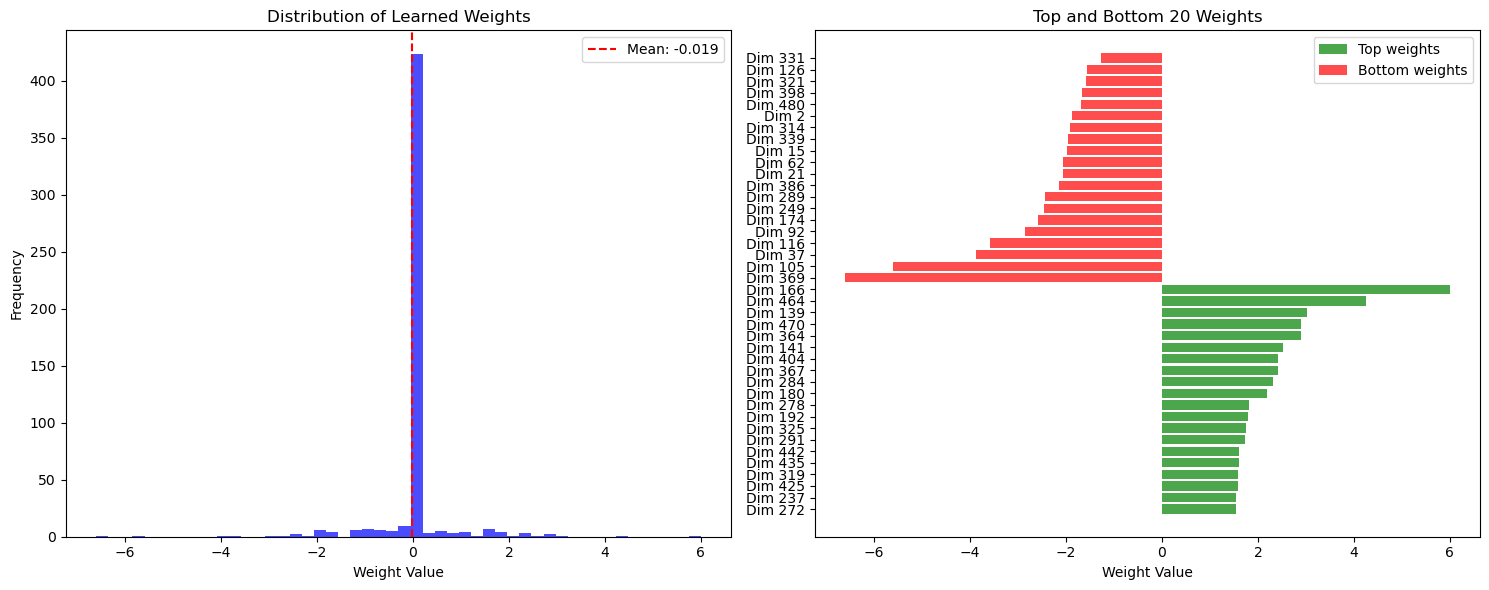


Weight Statistics:
Mean: -0.0189
Std: 0.8087
Min: -6.6054 (Dimension 369)
Max: 5.9978 (Dimension 272)

Number of weights > 0.1: 42
Number of weights < 0.1: 470
Number of weights ≈ 0 (|w| < 0.1): 421


In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the learned weights
learned_weights = model.weights.detach().numpy()


# Sort weights by magnitude for better visualization
sorted_indices = np.argsort(learned_weights)
sorted_weights = learned_weights[sorted_indices]

# Create figure
plt.figure(figsize=(15, 6))

# Main weight distribution plot
plt.subplot(1, 2, 1)
plt.hist(learned_weights, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Learned Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.axvline(x=learned_weights.mean(), color='red', linestyle='--', label=f'Mean: {learned_weights.mean():.3f}')
plt.legend()

# Top/bottom weights plot
plt.subplot(1, 2, 2)
n_top = 20  # number of top/bottom weights to show

# Plot top and bottom weights
plt.barh(range(n_top), sorted_weights[-n_top:], color='green', alpha=0.7, label='Top weights')
plt.barh(range(n_top, 2*n_top), sorted_weights[:n_top], color='red', alpha=0.7, label='Bottom weights')

plt.yticks(range(2*n_top), 
          [f'Dim {sorted_indices[-i-1]}' for i in range(n_top)] + 
          [f'Dim {sorted_indices[i]}' for i in range(n_top)])
plt.title(f'Top and Bottom {n_top} Weights')
plt.xlabel('Weight Value')
plt.legend()

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nWeight Statistics:")
print(f"Mean: {learned_weights.mean():.4f}")
print(f"Std: {learned_weights.std():.4f}")
print(f"Min: {learned_weights.min():.4f} (Dimension {sorted_indices[0]})")
print(f"Max: {learned_weights.max():.4f} (Dimension {sorted_indices[-1]})")

# Count weights approximately equal to 0
epsilon = 0.1  # You can adjust this threshold as needed
print(f"\nNumber of weights > {epsilon}: {np.sum(learned_weights > epsilon)}")
print(f"Number of weights < {epsilon}: {np.sum(learned_weights < epsilon)}")


zero_weights = np.sum(np.abs(learned_weights) < epsilon)
print(f"Number of weights ≈ 0 (|w| < {epsilon}): {zero_weights}")

In [44]:
#np.save('learned_cosine_weights_network.npy', learned_weights)

Baseline un-weighted cosine sim score.

In [67]:
def evaluate_cosine_baseline(pairs_data, embeddings, weights=None):
    sigmoid = nn.Sigmoid()
    all_preds = []
    all_labels = []
    
    # Track predictions for positive and negative pairs separately
    pos_correct = 0
    pos_total = 0
    neg_correct = 0
    neg_total = 0
    
    for i, j, label in pairs_data:
        emb1 = embeddings[i].unsqueeze(0)
        emb2 = embeddings[j].unsqueeze(0)
        
        if weights is not None:
            emb1 = emb1 * weights
            emb2 = emb2 * weights
        
        cos_sim = nn.functional.cosine_similarity(emb1, emb2)
        output = sigmoid(cos_sim)
        pred = (output > 0.5).float()
        
        # Track performance by pair type
        if label == 1:
            pos_total += 1
            if pred.item() == label:
                pos_correct += 1
        else:
            neg_total += 1
            if pred.item() == label:
                neg_correct += 1
        
        all_preds.append(pred.item())
        all_labels.append(label)
    
    # Calculate overall metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds)
    
    # Calculate and print separate metrics
    pos_acc = pos_correct / pos_total if pos_total > 0 else 0
    neg_acc = neg_correct / neg_total if neg_total > 0 else 0
    
    print(f"Positive pairs accuracy: {pos_acc:.3f} ({pos_correct}/{pos_total})")
    print(f"Negative pairs accuracy: {neg_acc:.3f} ({neg_correct}/{neg_total})")
    print(f"Overall accuracy: {accuracy:.3f}")
    print(f"F1 score: {f1:.3f}")
    
    return accuracy, f1

# Test unweighted version
train_acc, train_f1 = evaluate_cosine_baseline(eval_pairs_data, embeddings)


print(f'Unweighted Baseline Eval - Acc: {train_acc:.4f}, F1: {train_f1:.4f}')


Positive pairs accuracy: 0.821 (1642/2000)
Negative pairs accuracy: 0.546 (1093/2000)
Overall accuracy: 0.684
F1 score: 0.722
Unweighted Baseline Eval - Acc: 0.6837, F1: 0.7219


Total pairs: 4000
Pairs with similarity > 0: 2860
Pairs with similarity <= 0: 1140

Mean similarity for positive pairs: 0.642
Mean similarity for negative pairs: 0.024


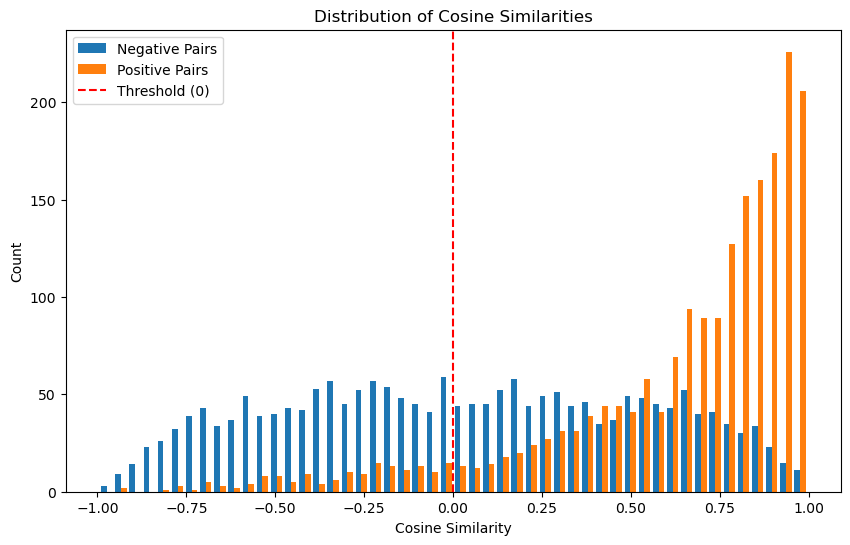

In [84]:
def analyze_cosine_similarities(pairs_data, embeddings, learned_weights=None, modelNN=None):
    all_similarities = []
    positive_similarities = []
    negative_similarities = []
    count_over_threshold = 0
    
    for i, j, label in pairs_data:
        emb1 = embeddings[i].unsqueeze(0)
        emb2 = embeddings[j].unsqueeze(0)
        
        # Apply learned weights if provided
        if learned_weights is not None:
            emb1 = emb1 * learned_weights
            emb2 = emb2 * learned_weights
            
        # Apply neural network projection if provided
        if modelNN is not None:
            # Use the projection part of the network without the sigmoid
            emb1 = modelNN.projection(emb1)
            emb2 = modelNN.projection(emb2)
        
        cos_sim = nn.functional.cosine_similarity(emb1, emb2).item()
        all_similarities.append(cos_sim)
        
        if cos_sim > 0:
            count_over_threshold += 1
            
        if label == 1:
            positive_similarities.append(cos_sim)
        else:
            negative_similarities.append(cos_sim)
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.hist([negative_similarities, positive_similarities], label=['Negative Pairs', 'Positive Pairs'], bins=50)
    plt.axvline(x=0, color='r', linestyle='--', label='Threshold (0)')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Count')
    plt.title('Distribution of Cosine Similarities')
    plt.legend()
    
    print(f"Total pairs: {len(pairs_data)}")
    print(f"Pairs with similarity > 0: {count_over_threshold}")
    print(f"Pairs with similarity <= 0: {len(pairs_data) - count_over_threshold}")
    print(f"\nMean similarity for positive pairs: {np.mean(positive_similarities):.3f}")
    print(f"Mean similarity for negative pairs: {np.mean(negative_similarities):.3f}")
    
    return all_similarities



#learned_weights = np.load('learned_cosine_weights_network.npy')
_ =analyze_cosine_similarities(eval_pairs_data, embeddings, modelNN = modelNN)

In [68]:
# This completely removes dims with less than threshold magnitude weight
def evaluate_cosine_baseline_with_threshold(pairs_data, embeddings, weights=None, threshold=1):
    sigmoid = nn.Sigmoid()
    all_preds = []
    all_labels = []
    
    # If weights provided, create mask for significant dimensions
    if weights is not None:
        significant_dims = torch.abs(weights) >= threshold
        # Filter embeddings and weights to only keep significant dimensions
        filtered_weights = weights[significant_dims]
    
    for i, j, label in pairs_data:
        emb1 = embeddings[i].unsqueeze(0)
        emb2 = embeddings[j].unsqueeze(0)
        
        if weights is not None:
            # Filter to significant dimensions
            emb1 = emb1[:, significant_dims]
            emb2 = emb2[:, significant_dims]
            # Apply remaining weights
            emb1 = emb1 * filtered_weights
            emb2 = emb2 * filtered_weights
        
        # Calculate cosine similarity and apply sigmoid
        cos_sim = nn.functional.cosine_similarity(emb1, emb2)
        output = sigmoid(cos_sim)
        
        pred = (output > 0.5).float()
        all_preds.append(pred.item())
        all_labels.append(label)
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds)
    
    # Calculate how many dimensions were kept
    if weights is not None:
        dims_kept = significant_dims.sum().item()
        dims_total = len(weights)
        print(f'Dimensions kept: {dims_kept}/{dims_total} ({(dims_kept/dims_total)*100:.1f}%)')
    
    return accuracy, f1

# Test unweighted version
train_acc, train_f1 = evaluate_cosine_baseline_with_threshold(train_pairs_data, embeddings, torch.tensor(learned_weights))
test_acc, test_f1 = evaluate_cosine_baseline_with_threshold(test_pairs_data, embeddings, torch.tensor(learned_weights))

print(f'Weighted Baseline Train - Acc: {train_acc:.4f}, F1: {train_f1:.4f}')
print(f'Weighted Baseline Test  - Acc: {test_acc:.4f}, F1: {test_f1:.4f}')



Dimensions kept: 51/512 (10.0%)
Dimensions kept: 51/512 (10.0%)
Weighted Baseline Train - Acc: 0.6749, F1: 0.7236
Weighted Baseline Test  - Acc: 0.6797, F1: 0.7291


ROC Curve unweighted vs weighted

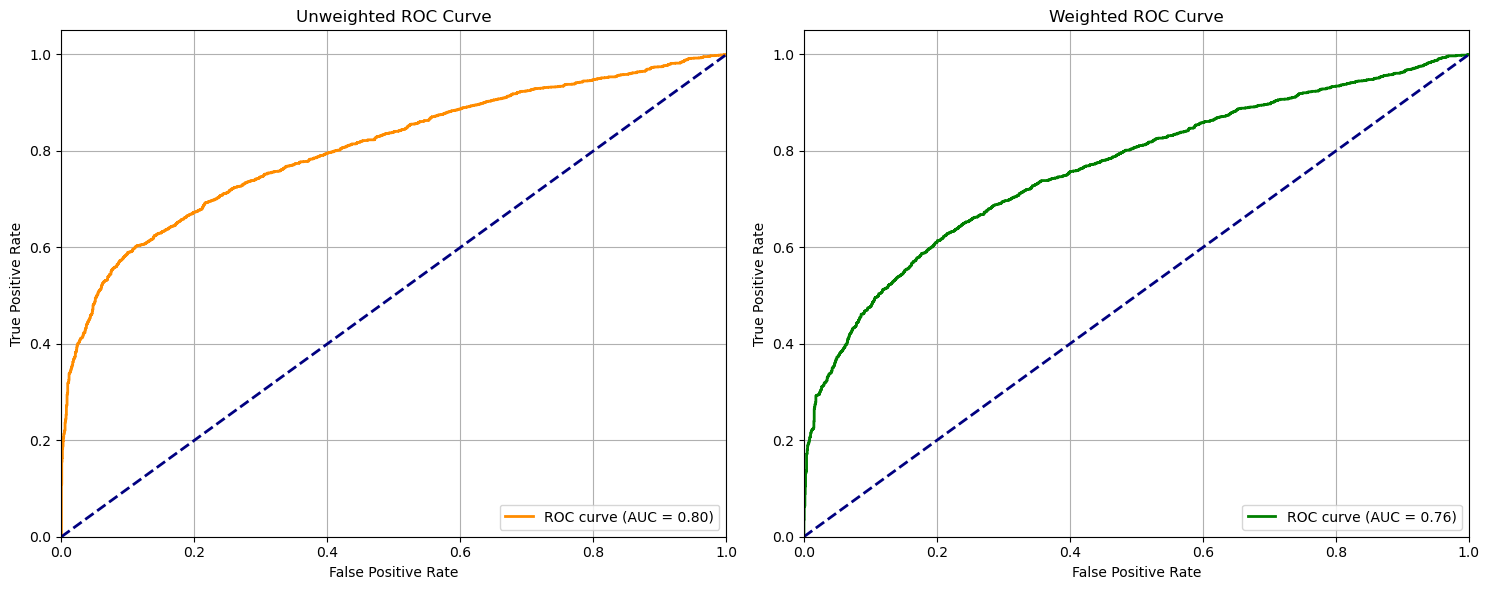

AUC improvement: -0.0418


In [69]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import numpy as np
def plot_roc_comparison(eval_loader, learned_weights):
    def get_predictions(dataloader, weights=None):
        all_probs = []
        all_labels = []
        
        for batch in dataloader:
            emb1 = batch['emb1']
            emb2 = batch['emb2']
            labels = batch['label']
            
            if weights is not None:
                # Apply weights
                emb1 = emb1 * torch.from_numpy(weights)
                emb2 = emb2 * torch.from_numpy(weights)
            
            # Compute cosine similarity
            cos_sim = nn.functional.cosine_similarity(emb1, emb2, dim=1)
            probs = torch.sigmoid(cos_sim).cpu().numpy()
            
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())
        
        return np.array(all_probs), np.array(all_labels)

    # Get predictions for both weighted and unweighted
    weighted_probs, true_labels = get_predictions(eval_loader, learned_weights)
    unweighted_probs, _ = get_predictions(eval_loader)

    # Calculate ROC curves
    fpr_weighted, tpr_weighted, _ = roc_curve(true_labels, weighted_probs)
    fpr_unweighted, tpr_unweighted, _ = roc_curve(true_labels, unweighted_probs)
    
    roc_auc_weighted = auc(fpr_weighted, tpr_weighted)
    roc_auc_unweighted = auc(fpr_unweighted, tpr_unweighted)

    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot unweighted ROC
    ax1.plot(fpr_unweighted, tpr_unweighted, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc_unweighted:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Unweighted ROC Curve')
    ax1.legend(loc="lower right")
    ax1.grid(True)

    # Plot weighted ROC
    ax2.plot(fpr_weighted, tpr_weighted, color='green', lw=2,
             label=f'ROC curve (AUC = {roc_auc_weighted:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Weighted ROC Curve')
    ax2.legend(loc="lower right")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    return roc_auc_unweighted, roc_auc_weighted

# Usage:
learned_weights = model.weights.detach().numpy()
unweighted_auc, weighted_auc = plot_roc_comparison(eval_loader, learned_weights)
print(f'AUC improvement: {weighted_auc - unweighted_auc:.4f}')

Neural Representation Instead

In [70]:
class EmbeddingNN(nn.Module):
    def __init__(self, input_dim, layer_sizes):
        super().__init__()
        
        # Build layers based on input list
        layers = []
        current_dim = input_dim
        
        # If single layer, just do direct projection
        if len(layer_sizes) == 1:
            layers.append(nn.Linear(current_dim, layer_sizes[0]))
        # If multiple layers, add ReLU between them
        else:
            for size in layer_sizes[:-1]:
                layers.extend([
                    nn.Linear(current_dim, size),
                    nn.ReLU()
                ])
                current_dim = size
            # Add final projection layer
            layers.append(nn.Linear(current_dim, layer_sizes[-1]))
        
        self.projection = nn.Sequential(*layers)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, emb1, emb2):
        proj1 = self.projection(emb1)
        proj2 = self.projection(emb2)
        
        cos_sim = nn.functional.cosine_similarity(proj1, proj2, dim=1)
        return self.sigmoid(cos_sim)

In [71]:
# Prepare data and train
train_pairs_data, embeddings = prepare_data(train_pos, train_neg, network_vector_df)
test_pairs_data, _ = prepare_data(test_pos, test_neg, network_vector_df)

train_dataset = PairDataset(train_pairs_data, embeddings)
test_dataset = PairDataset(test_pairs_data, embeddings)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

modelNN = EmbeddingNN(input_dim=512, layer_sizes=[5])

In [76]:
modelNN = train_model(modelNN, train_loader, test_loader, num_epochs=5, learning_rate=1e-4)

Epoch 1:
Train - Loss: 0.5765, Acc: 0.7257, F1: 0.7705
Val   - Loss: 0.5867, Acc: 0.7080, F1: 0.7584

Epoch 2:
Train - Loss: 0.5763, Acc: 0.7263, F1: 0.7708
Val   - Loss: 0.5866, Acc: 0.7080, F1: 0.7581

Epoch 3:
Train - Loss: 0.5762, Acc: 0.7259, F1: 0.7708
Val   - Loss: 0.5866, Acc: 0.7087, F1: 0.7590

Epoch 4:
Train - Loss: 0.5759, Acc: 0.7265, F1: 0.7712
Val   - Loss: 0.5866, Acc: 0.7074, F1: 0.7580

Epoch 5:
Train - Loss: 0.5758, Acc: 0.7272, F1: 0.7717
Val   - Loss: 0.5867, Acc: 0.7069, F1: 0.7576



In [77]:
# Prepare evaluation data
eval_pairs_data, _ = prepare_data(eval_pos, eval_neg, network_vector_df)
eval_dataset = PairDataset(eval_pairs_data, embeddings)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

# Run evaluation
eval_acc, eval_f1, eval_loss = evaluate_model(modelNN, eval_loader)
print(f'Evaluation Results:')
print(f'Accuracy: {eval_acc:.4f}')
print(f'F1 Score: {eval_f1:.4f}')
print(f'Loss: {eval_loss:.4f}')

Evaluation Results:
Accuracy: 0.7070
F1 Score: 0.7588
Loss: 0.5868


In [78]:
torch.save(modelNN, 'neural_rep_network.pt')

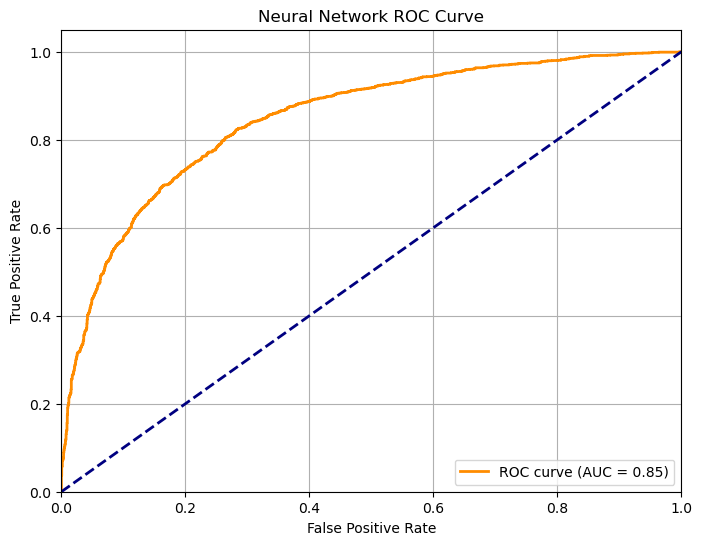

AUC: 0.8465


In [79]:
def plot_neural_net_roc(model, eval_loader):
    model.eval()
    all_probs = []
    all_labels = []
    
    # Get predictions
    with torch.no_grad():
        for batch in eval_loader:
            emb1 = batch['emb1']
            emb2 = batch['emb2']
            labels = batch['label']
            
            outputs = model(emb1, emb2)
            all_probs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Neural Network ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return roc_auc

# Usage:
auc_score = plot_neural_net_roc(modelNN, eval_loader)
print(f'AUC: {auc_score:.4f}')